## Install Dependencies

In [ ]:
!pip install -qq 'openinference-instrumentation-llama-index>=0.1.6' 'openinference-instrumentation-llama-index>=0.1.6'  llama-index-llms-openai opentelemetry-exporter-otlp llama-index>=0.10.3 "llama-index-callbacks-arize-phoenix>=0.1.2" arize-otel litellm

## Add Open AI API Key to Environment

In [ ]:
import os
from getpass import getpass

openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

## Register OTEL and Instrument LlamaIndex to Send Traces to Arize

In [ ]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from arize_otel import register_otel, Endpoints
from datetime import datetime


now = datetime.now()
dt_string = now.strftime("%d/%m %H:%M")

# Setup OTEL via our convenience function
register_otel(
    endpoints = Endpoints.ARIZE,
    space_key = getpass("🔑 Enter your Arize space key in the space settings page of the Arize UI: "),
    api_key = getpass("🔑 Enter your Arize API key in the space settings page of the Arize UI: "),
    model_id = f"tutorial-rag-hallucination-guard-{dt_string}",
)
LlamaIndexInstrumentor().instrument()

## Install Guardrails AI

Note that Guardrails AI needs to be installed after setting up the LlamaIndexInstrumentor due to dependency issues.

In [ ]:
!pip install -qq guardrails-ai

## Install LlmRagEvaluator Guard Repo

In [ ]:
!pip install --no-cache-dir -qq git+https://github.com/Arize-ai/rag-llm-prompt-evaluator-guard

## Instantiate LlmRagEvaluator Guard with HallucinationPrompt

The `LlmRagEvaluator` can be instantiated using an off-the-shelf prompt from Arize (`HallucinationPrompt`, `ContextRelevancyPrompt` or `QACorrectnessPrompt`). Alternatively, it can be instantiated with a custom prompt that inherits from `ArizeRagEvalPromptBase`. This tutorial will use the prompt from `HallucinationPrompt`. For visibility, the code is copied from the repo below.

In [ ]:
from abc import ABC, abstractmethod


class ArizeRagEvalPromptBase(ABC):
    def __init__(self, prompt_name, **kwargs) -> None:
        self.prompt_name = prompt_name

    @abstractmethod
    def generate_prompt(self, user_input_message: str, reference_text: str, llm_response: str) -> str:
        pass


class HallucinationPrompt(ArizeRagEvalPromptBase):
    def generate_prompt(self, user_input_message: str, reference_text: str, llm_response: str) -> str:
        return f"""
            In this task, you will be presented with a query, a reference text and an answer. The answer is
            generated to the question based on the reference text. The answer may contain false information. You
            must use the reference text to determine if the answer to the question contains false information,
            if the answer is a hallucination of facts. Your objective is to determine whether the answer text
            contains factual information and is not a hallucination. A 'hallucination' refers to
            an answer that is not based on the reference text or assumes information that is not available in
            the reference text. Your response should be a single word: either "factual" or "hallucinated", and
            it should not include any other text or characters. "hallucinated" indicates that the answer
            provides factually inaccurate information to the query based on the reference text. "factual"
            indicates that the answer to the question is correct relative to the reference text, and does not
            contain made up information. Please read the query and reference text carefully before determining
            your response.

                [BEGIN DATA]
                ************
                [Query]: {user_input_message}
                ************
                [Reference text]: {reference_text}
                ************
                [Answer]: {llm_response}
                ************
                [END DATA]

                Is the answer above factual or hallucinated based on the query and reference text?
            """

In [ ]:
from guardrails import Guard
from validator import LlmRagEvaluator


model = "gpt-4o-mini"
guard = Guard.from_string(
            validators=[
                LlmRagEvaluator(
                    eval_llm_prompt_generator=HallucinationPrompt(prompt_name="hallucination_judge_llm"),
                    llm_evaluator_fail_response="hallucinated",
                    llm_evaluator_pass_response="factual",
                    llm_callable=model,
                    on_fail="exception",
                    on="prompt")
            ],
        )
guard._disable_tracer = True

## Set Up Guarded LLM Call

In [ ]:
import openai
from typing import Optional, List, Mapping, Any

from llama_index.core import SimpleDirectoryReader, SummaryIndex
from llama_index.core.callbacks import CallbackManager
from llama_index.core.llms import (
    CustomLLM,
    CompletionResponse,
    CompletionResponseGen,
    LLMMetadata,
)
from llama_index.core.llms.callbacks import llm_completion_callback
from llama_index.core import Settings

from llama_index.llms.openai import OpenAI

def monkey_completion(prompt, **kwargs):
    # String match how LlamaIndex processes RAG prompts
    _, _, context_component_of_prompt = prompt.partition("Context information is below.")
    _, _, query_component_of_prompt = prompt.partition("Query: ")
    # Pass context and user message into guarded LLM call
    return guard(
      llm_api=openai.chat.completions.create,
      prompt=prompt,
      model=model,
      max_tokens=1024,
      temperature=0.5,
      metadata={
        "user_message": query_component_of_prompt,
        "context": context_component_of_prompt,
      }
    )

outerOpenAI = OpenAI()

class GuardedLLM(CustomLLM):
    context_window: int = 3900
    num_output: int = 256
    model_name: str = "custom"
    dummy_response: str = "My response"
    openai_llm: Any = None

    @property
    def metadata(self) -> LLMMetadata:
        """Get LLM metadata."""
        return outerOpenAI.metadata

    @llm_completion_callback()
    def complete(self, prompt: str, **kwargs: Any) -> CompletionResponse:
        validated_response = monkey_completion(prompt, **kwargs)
        return CompletionResponse(text=validated_response.raw_llm_output)

    @llm_completion_callback()
    def stream_complete(
        self, prompt: str, **kwargs: Any
    ) -> CompletionResponseGen:
        response = ""
        for token in self.dummy_response:
            response += token
            yield CompletionResponse(text=response, delta=token)

# Set Up RAG Application
Create a LlamaIndex VectorStore for a RAG application over the Arize docs.

In [ ]:
from gcsfs import GCSFileSystem
from llama_index.core import StorageContext, load_index_from_storage


file_system = GCSFileSystem(project="public-assets-275721")
index_path = "arize-phoenix-assets/datasets/unstructured/llm/llama-index/arize-docs/index/"
storage_context = StorageContext.from_defaults(
    fs=file_system,
    persist_dir=index_path,
)
index = load_index_from_storage(
    storage_context,
)
query_engine = index.as_query_engine(llm=GuardedLLM(),)


## Send Message to Query Engine
Below is an example where we send a message to the LLM that's outside of the scope of the docs. The LLM hallucinates a response and the LLM Judge Guard flags that the LLM hallucinated.

Replace `logging.INFO` with `logging.DEBUG` to see the calls logged inside the Guard.

In [ ]:
from guardrails.errors import ValidationError
import logging


logging.getLogger().setLevel(logging.INFO)

sample_prompt = "How do I trace NeMo in Arize?"
try:
  response = query_engine.query(sample_prompt)
  print("Validation Passed")
  print(response)
except ValidationError as e:
  print("Validation Failed")
  print(e)

## View Traces in Arize
We can view the user message and context sent to the original LLM in Arize.

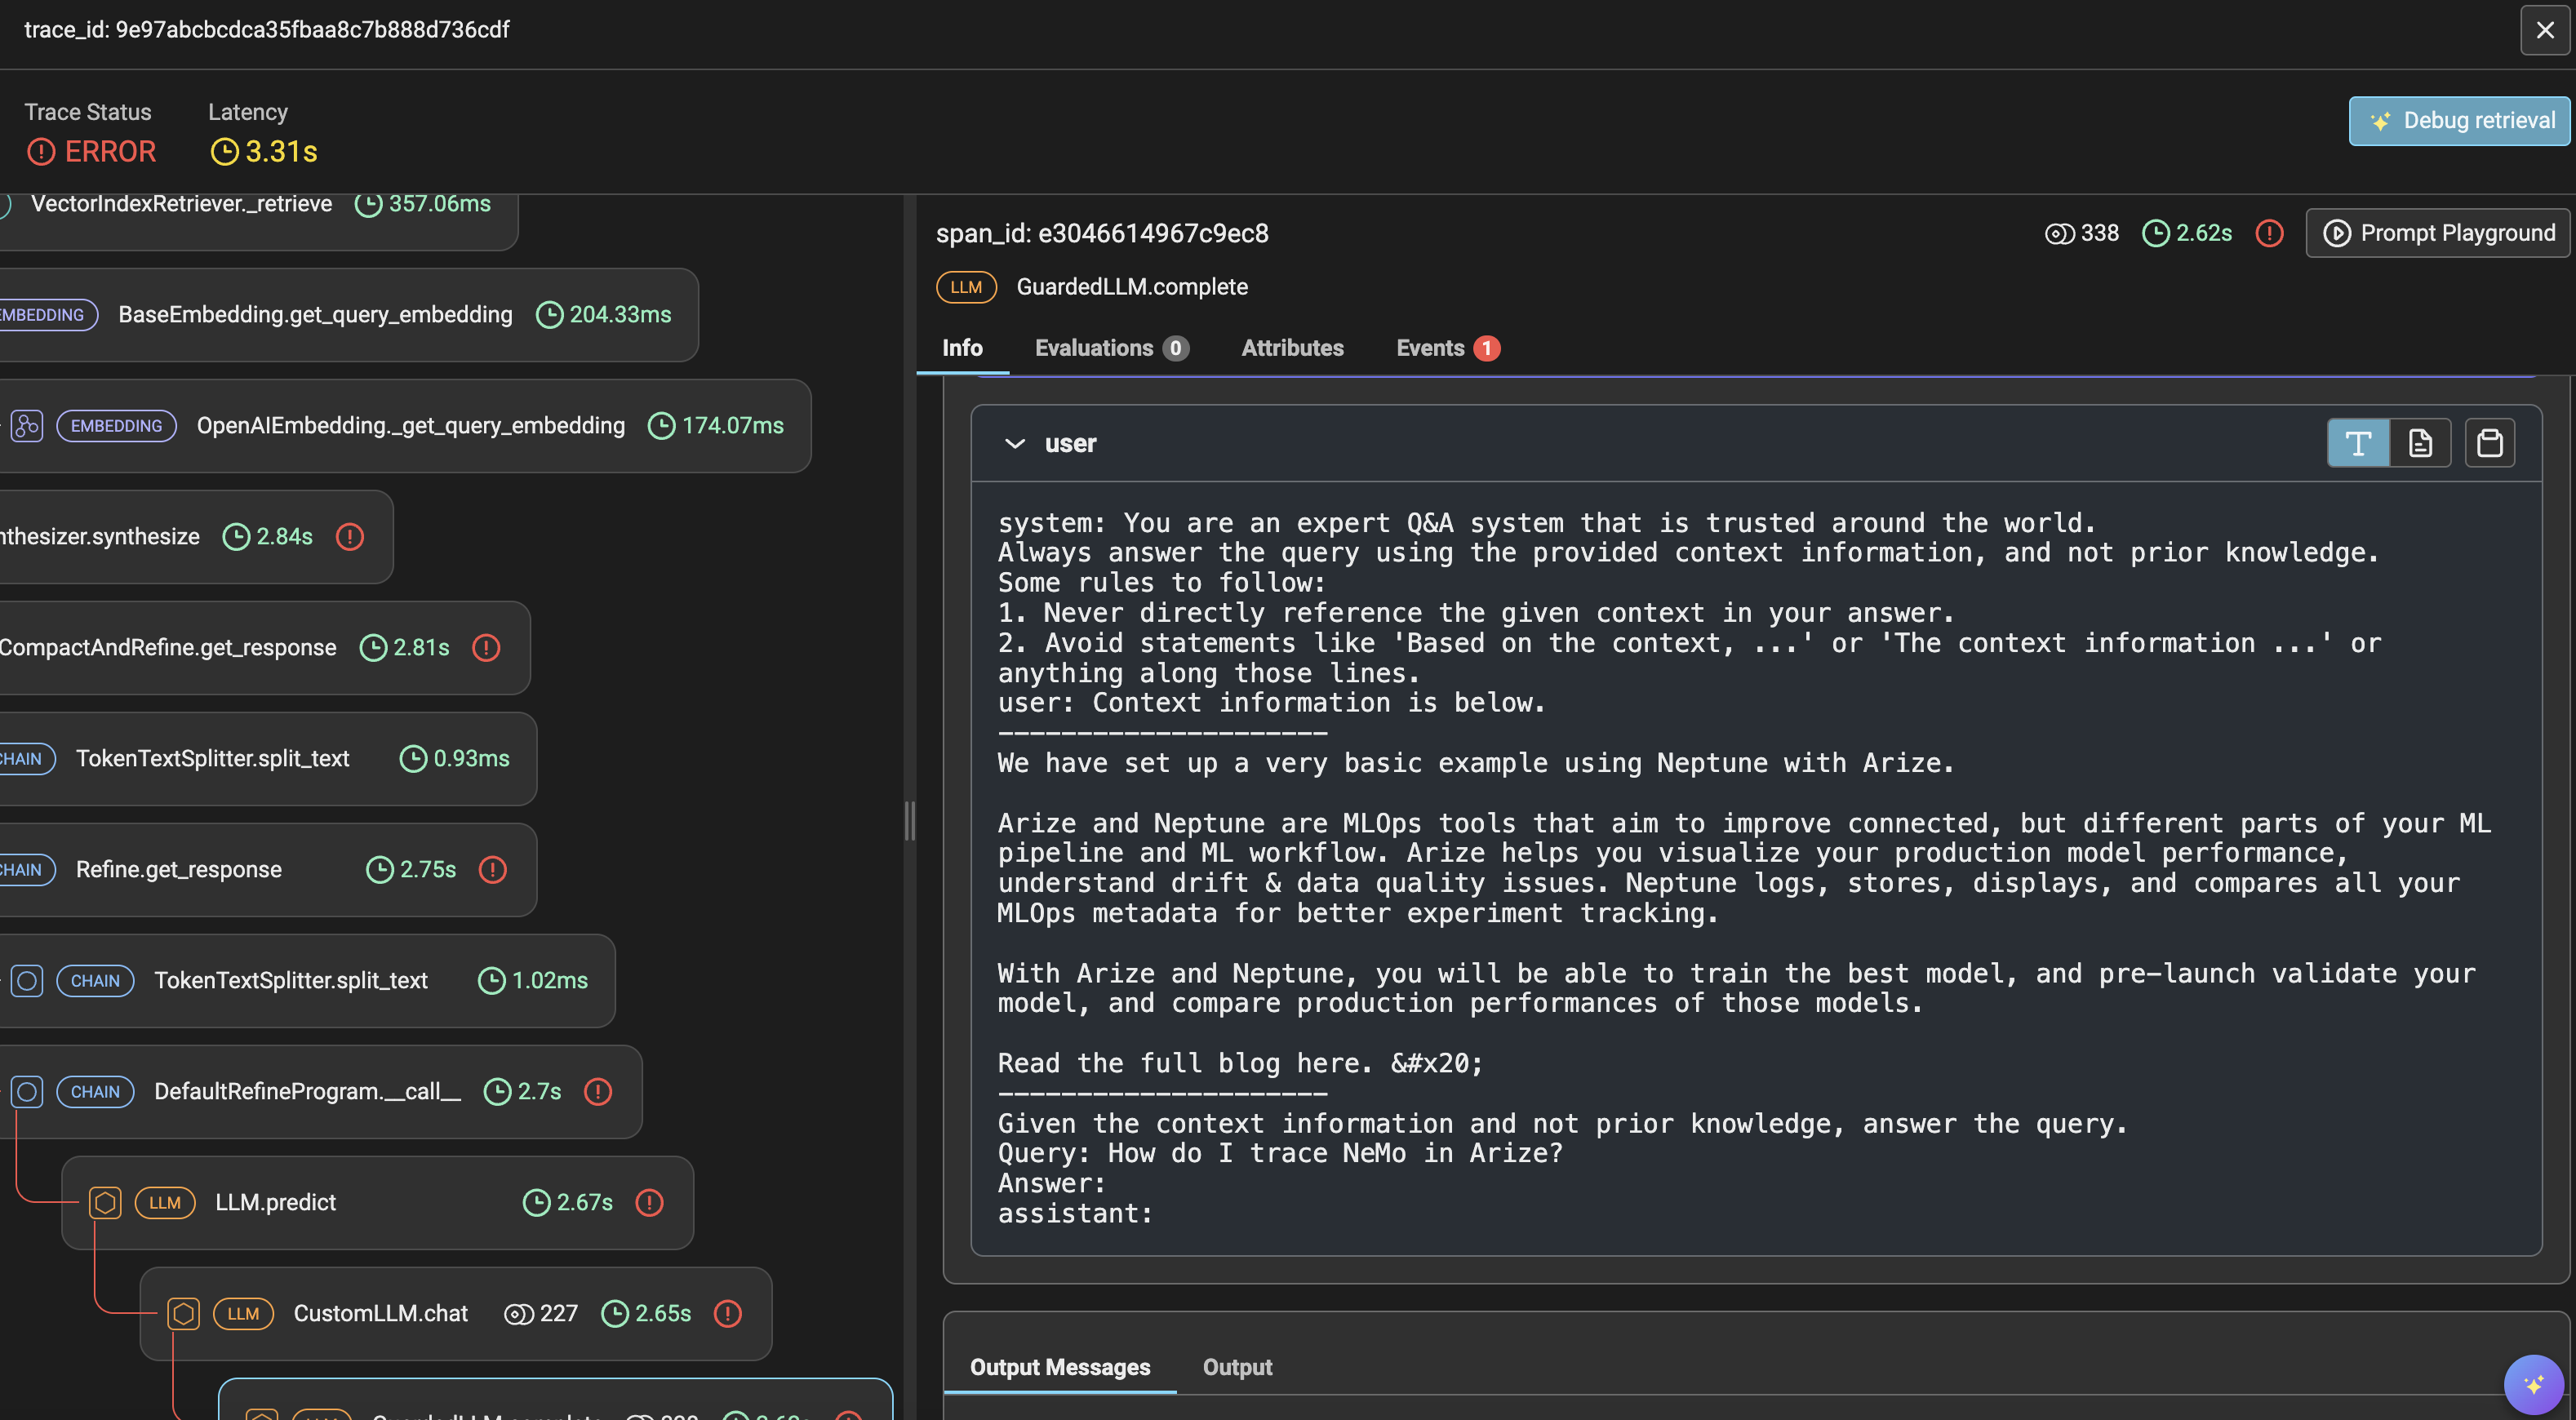

The `assistant` message shows the original LLM response that the Guard evaluated.

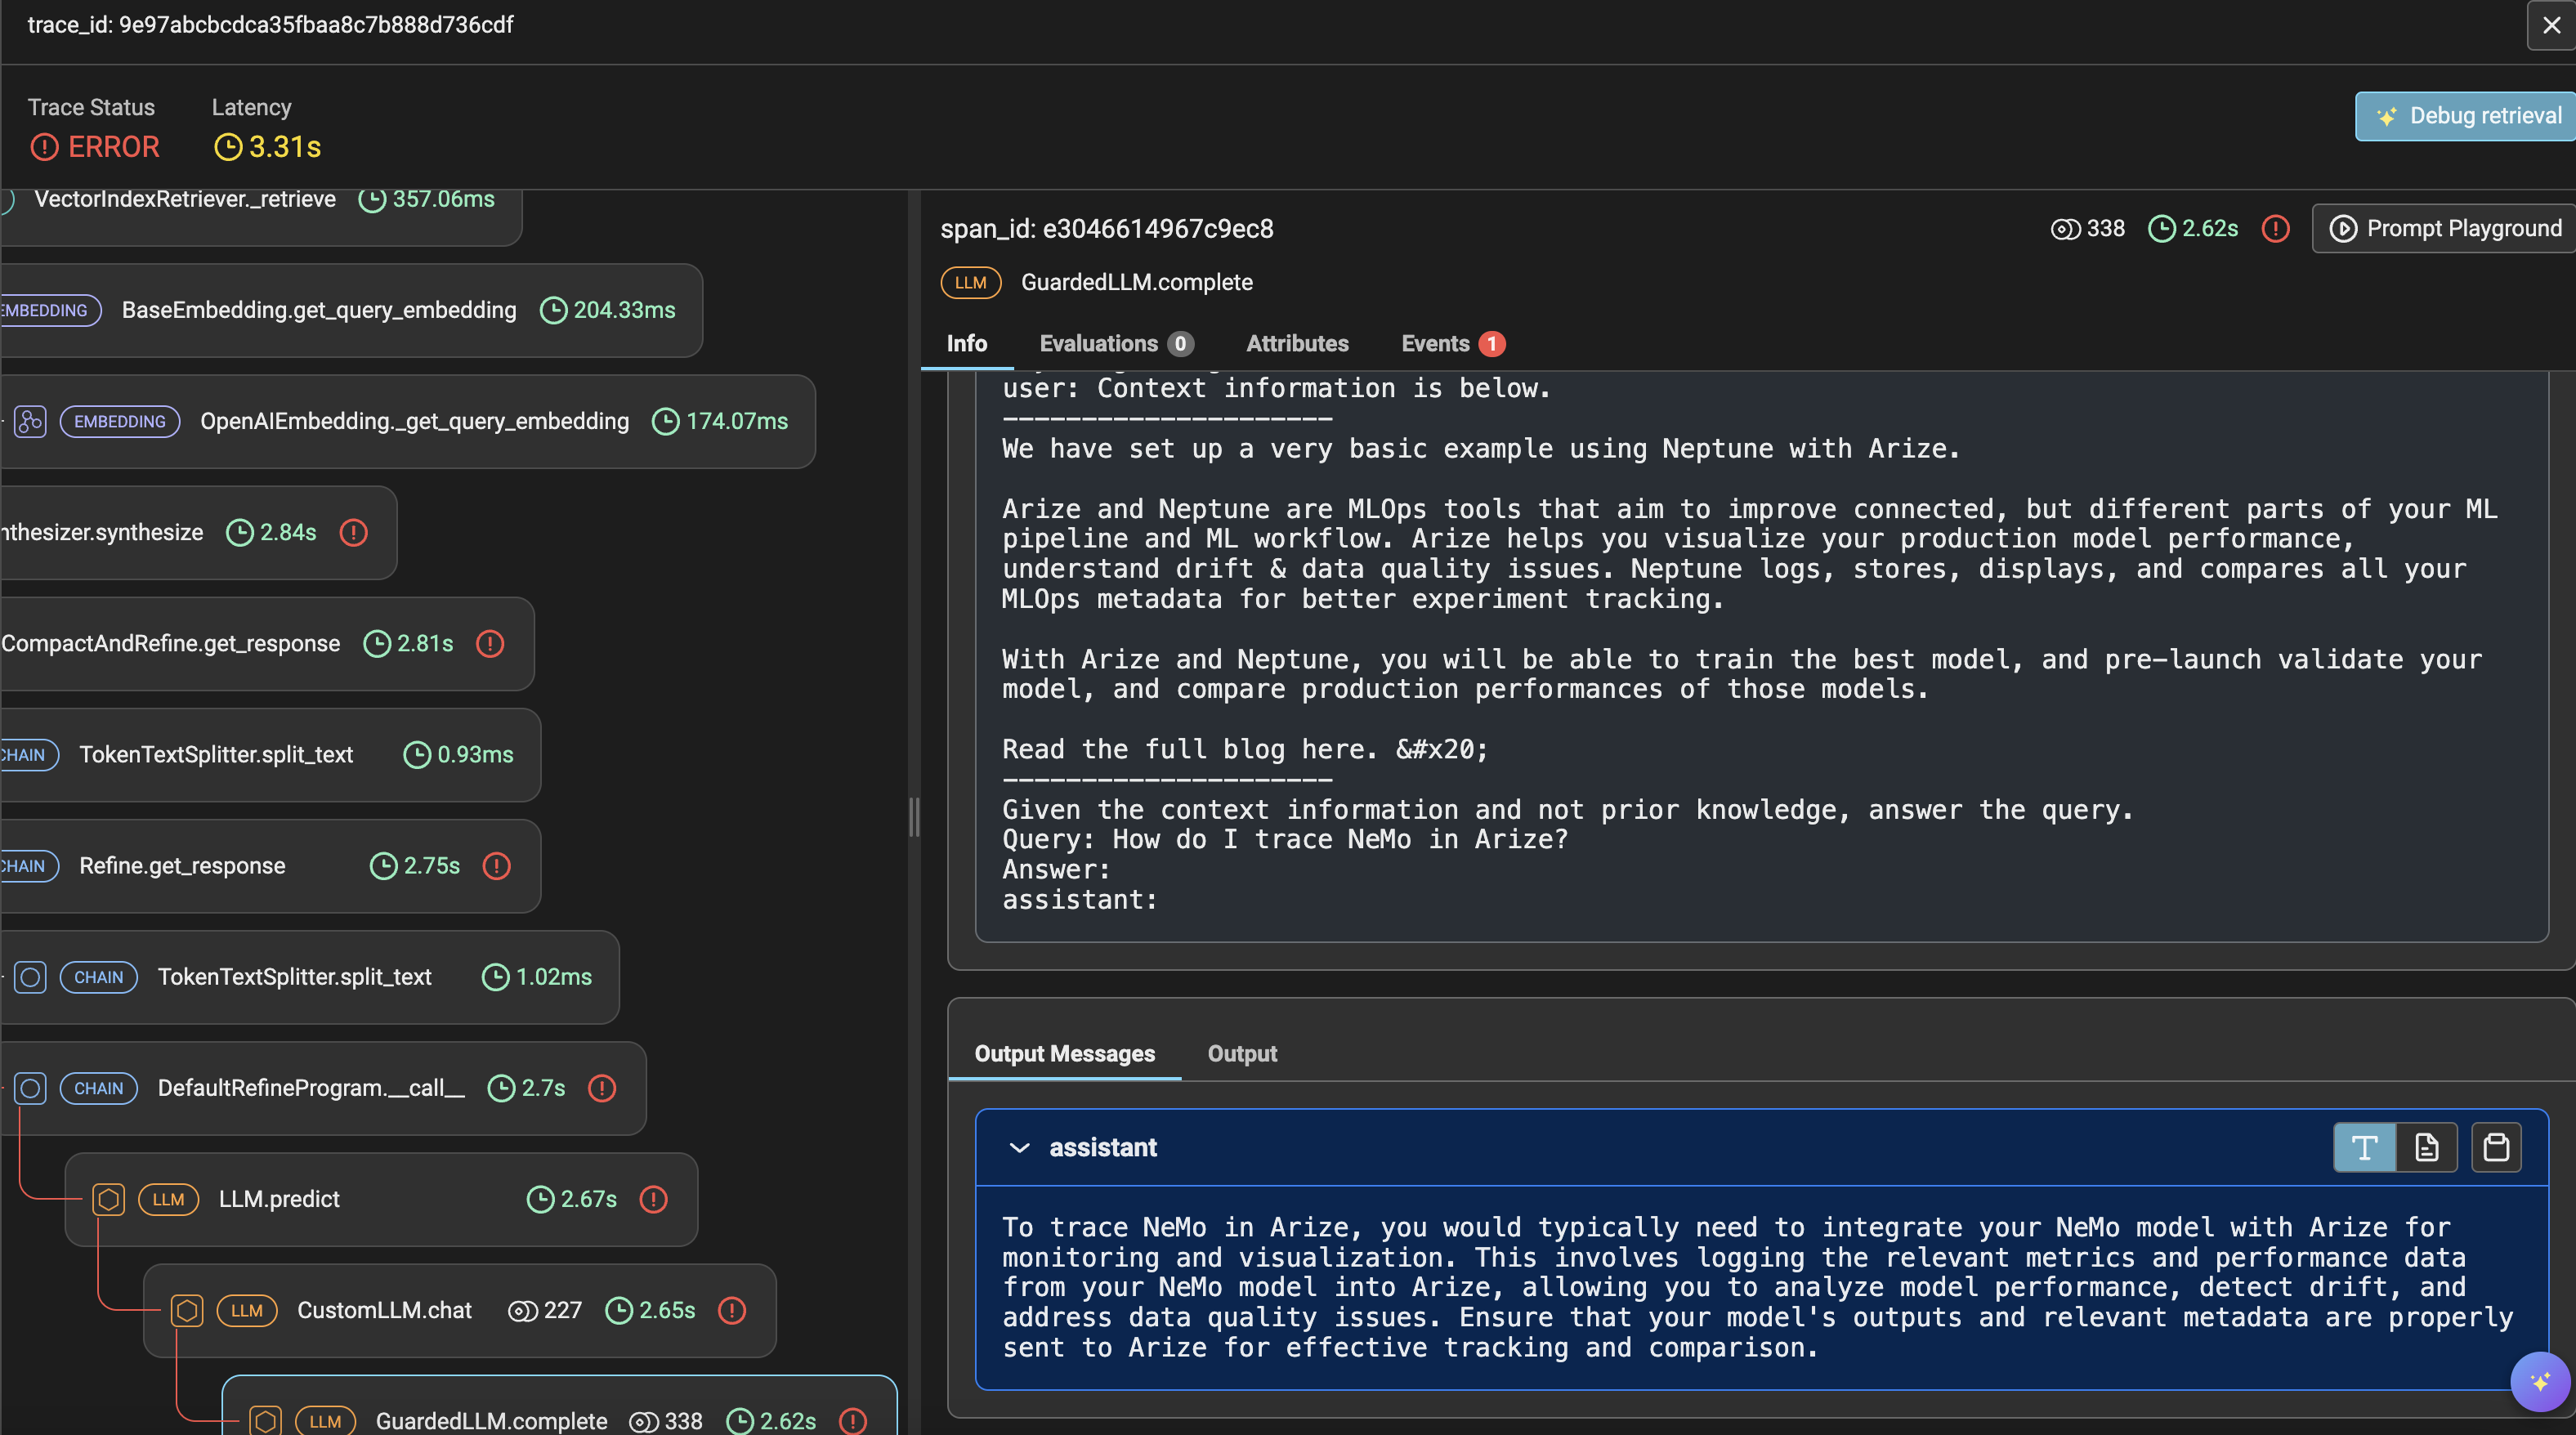

The `exception` below shows the response from the Guard, where it flags that the LLM response is a hallucination, since NeMo is not referenced in the context.

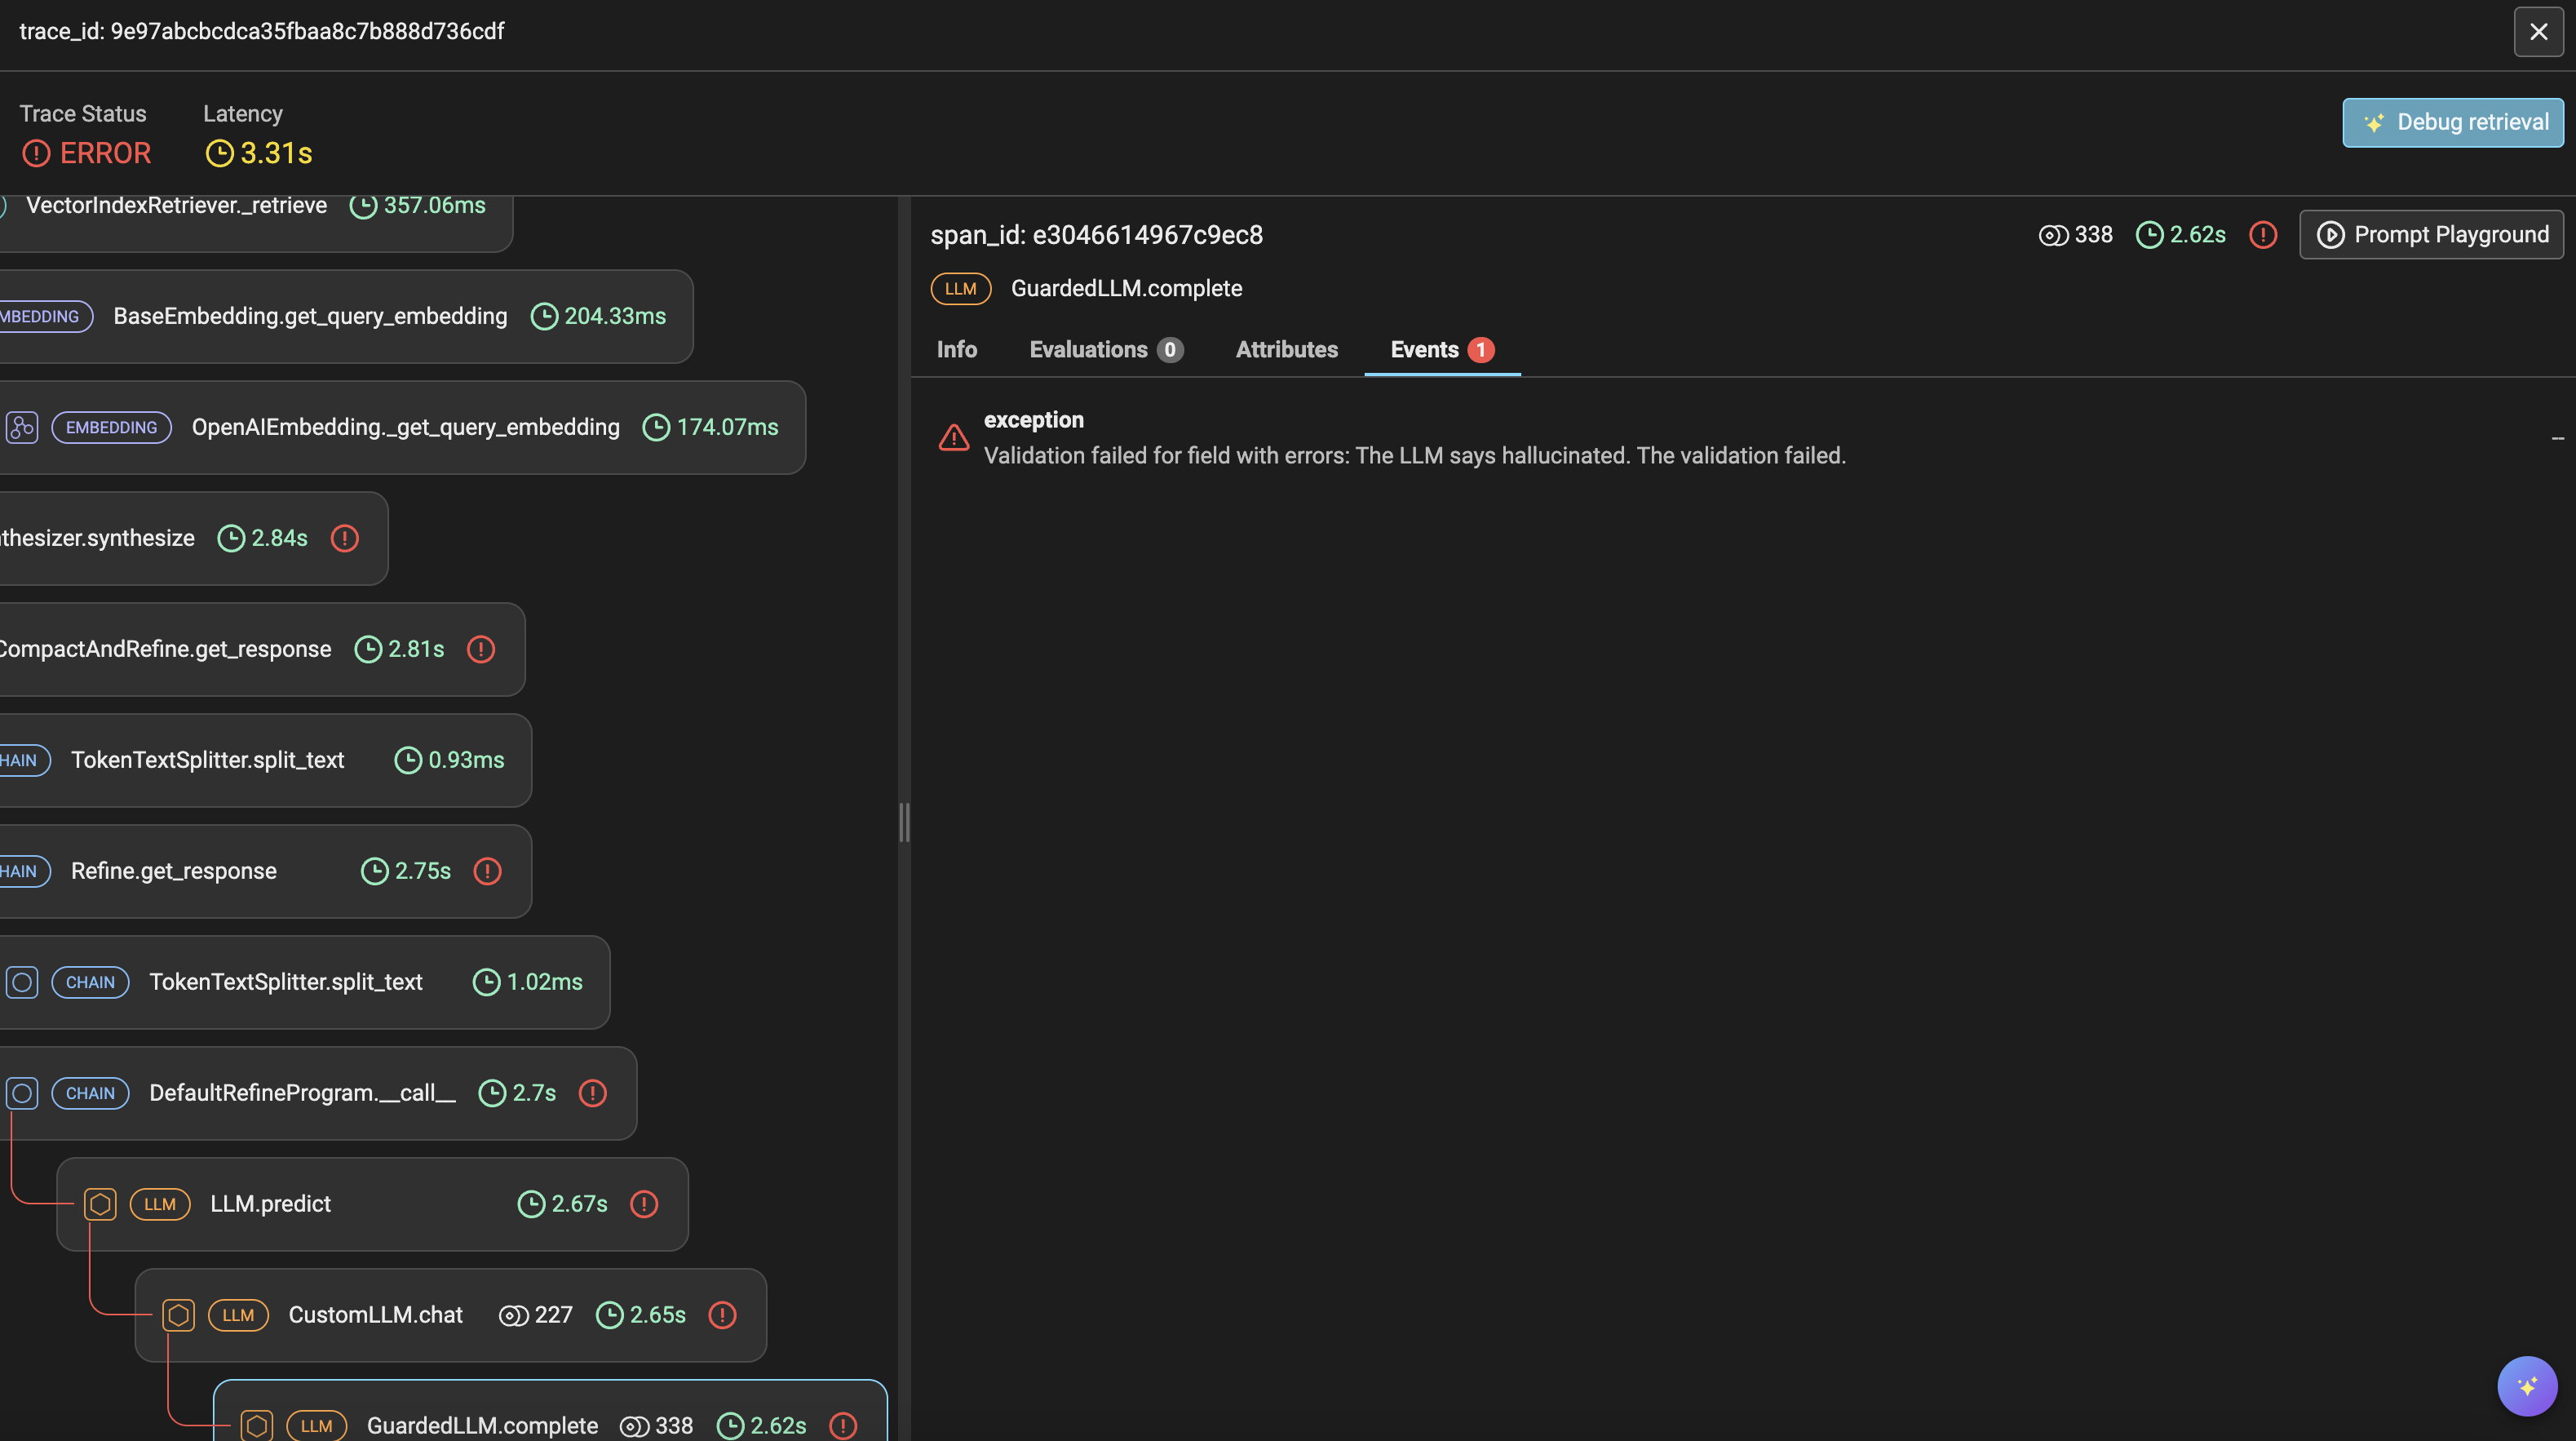

We can navigate over to the `Prompt Playground` to improve the LLM system prompt so that it is less likely to hallucinate in the future.

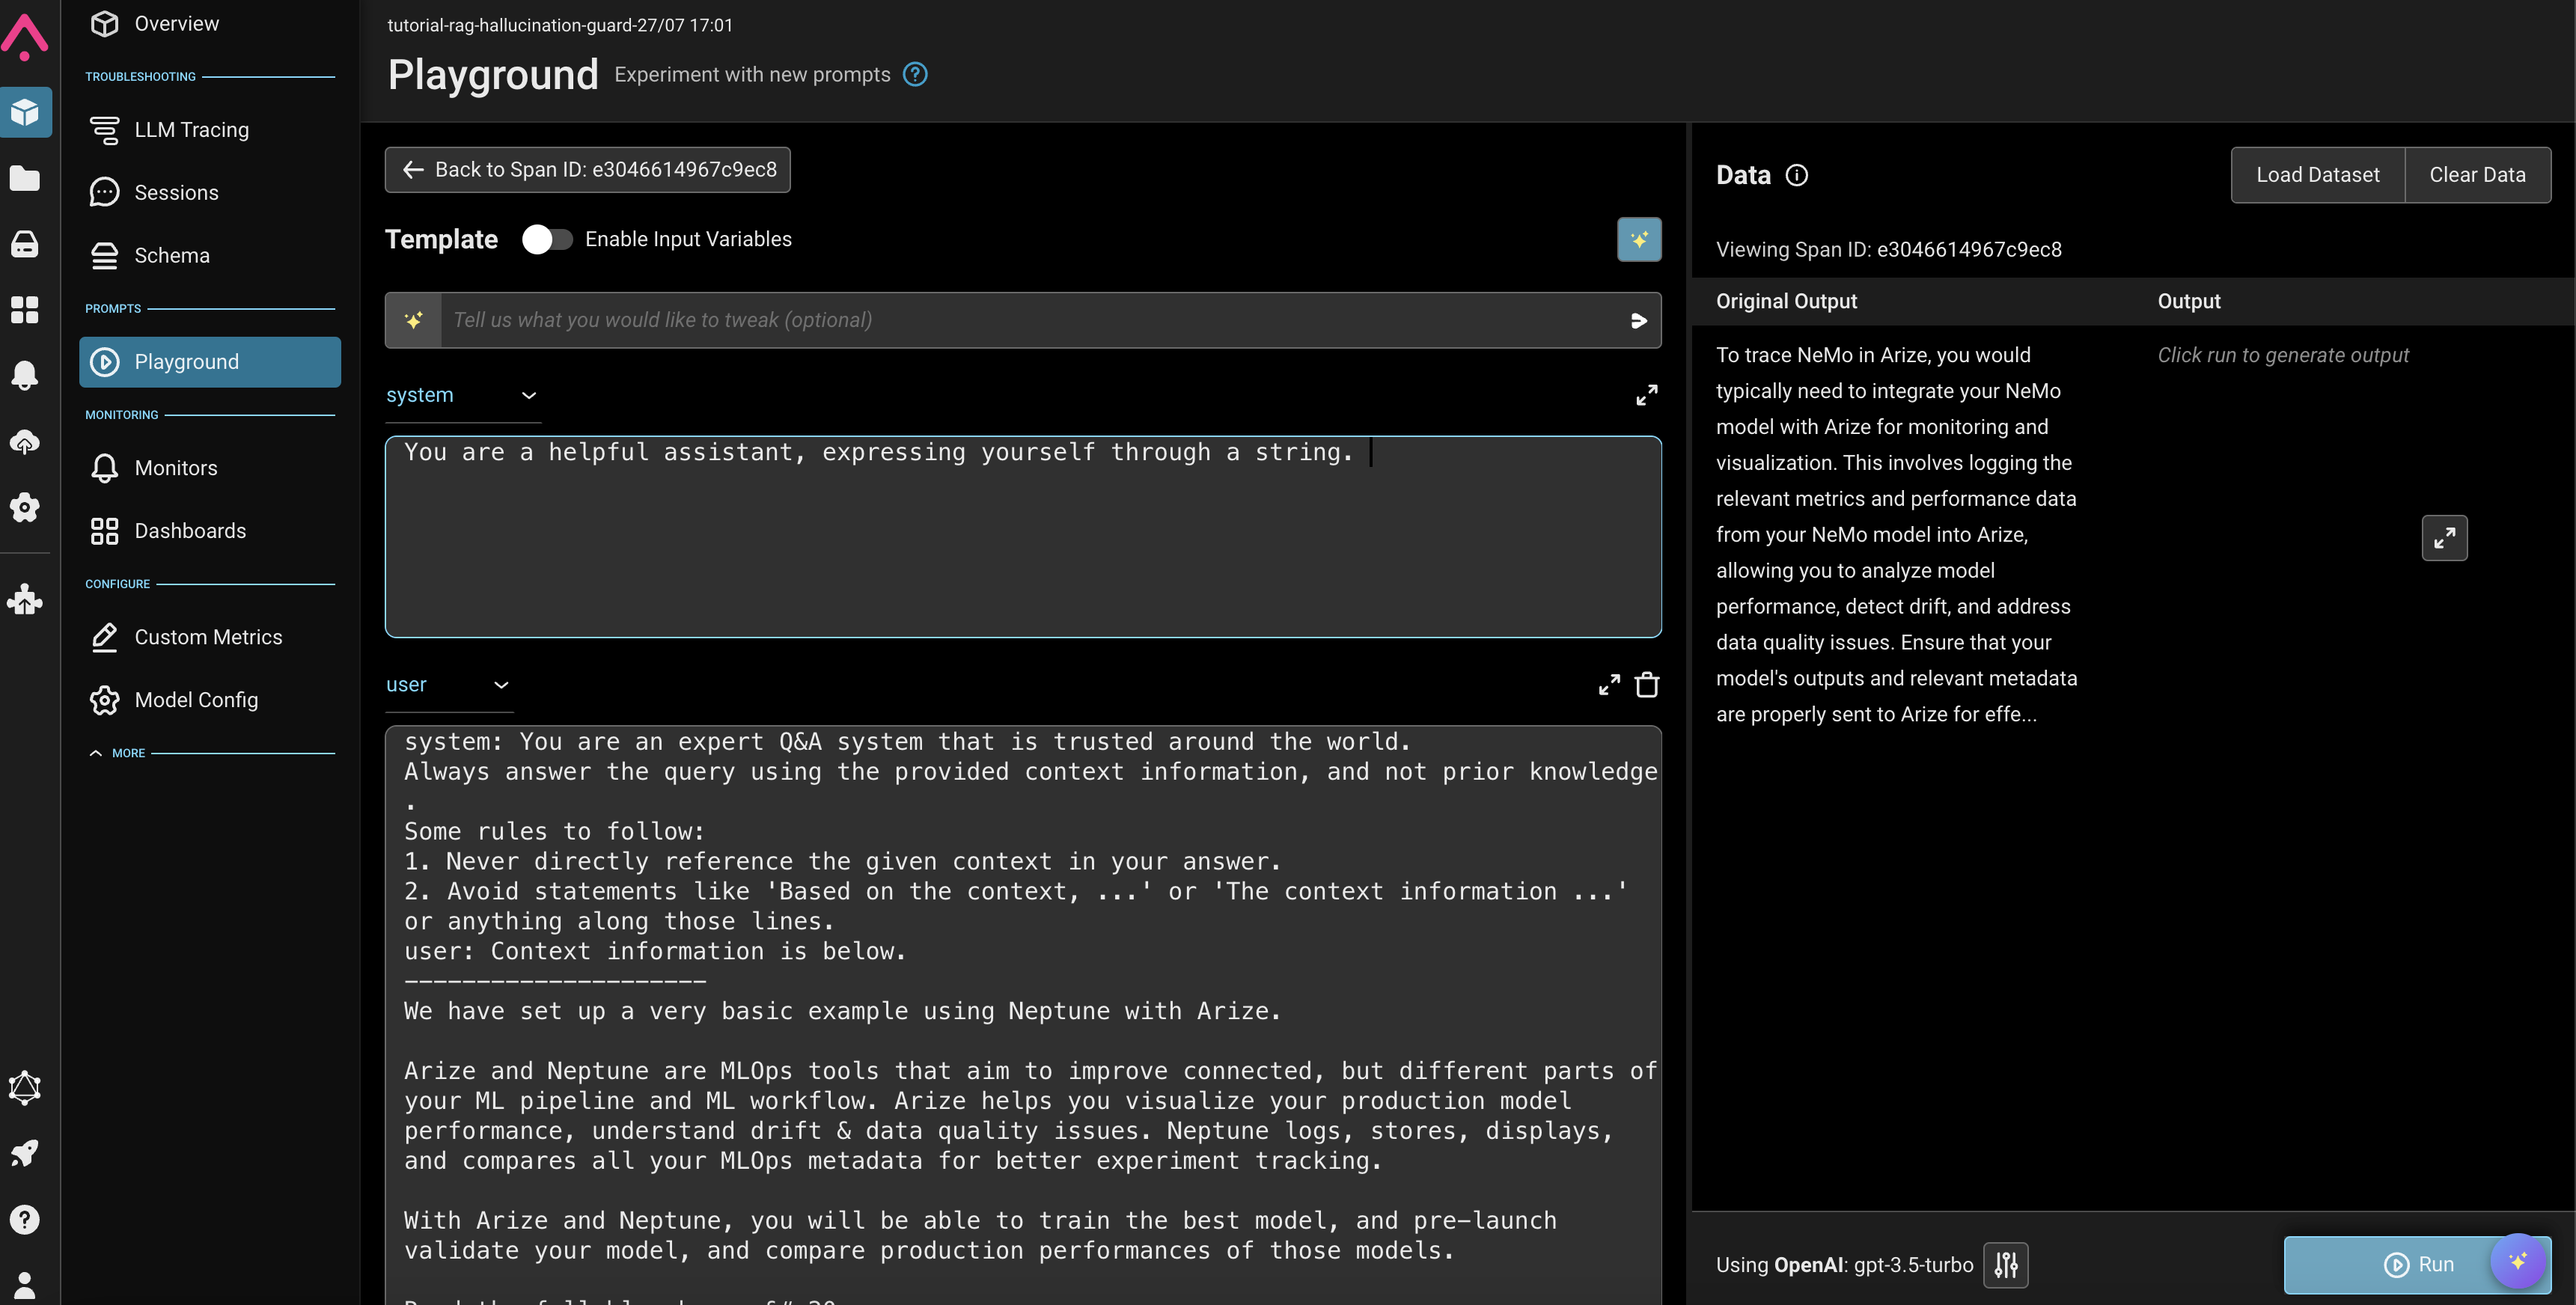



We add the sentence `IF YOU DO NOT KNOW THE ANSWER, SAY "I DON'T KNOW"` to the `system` prompt. When we re-run the LLM, the model responds with "I DON'T KNOW" instead of hallucinating a response.

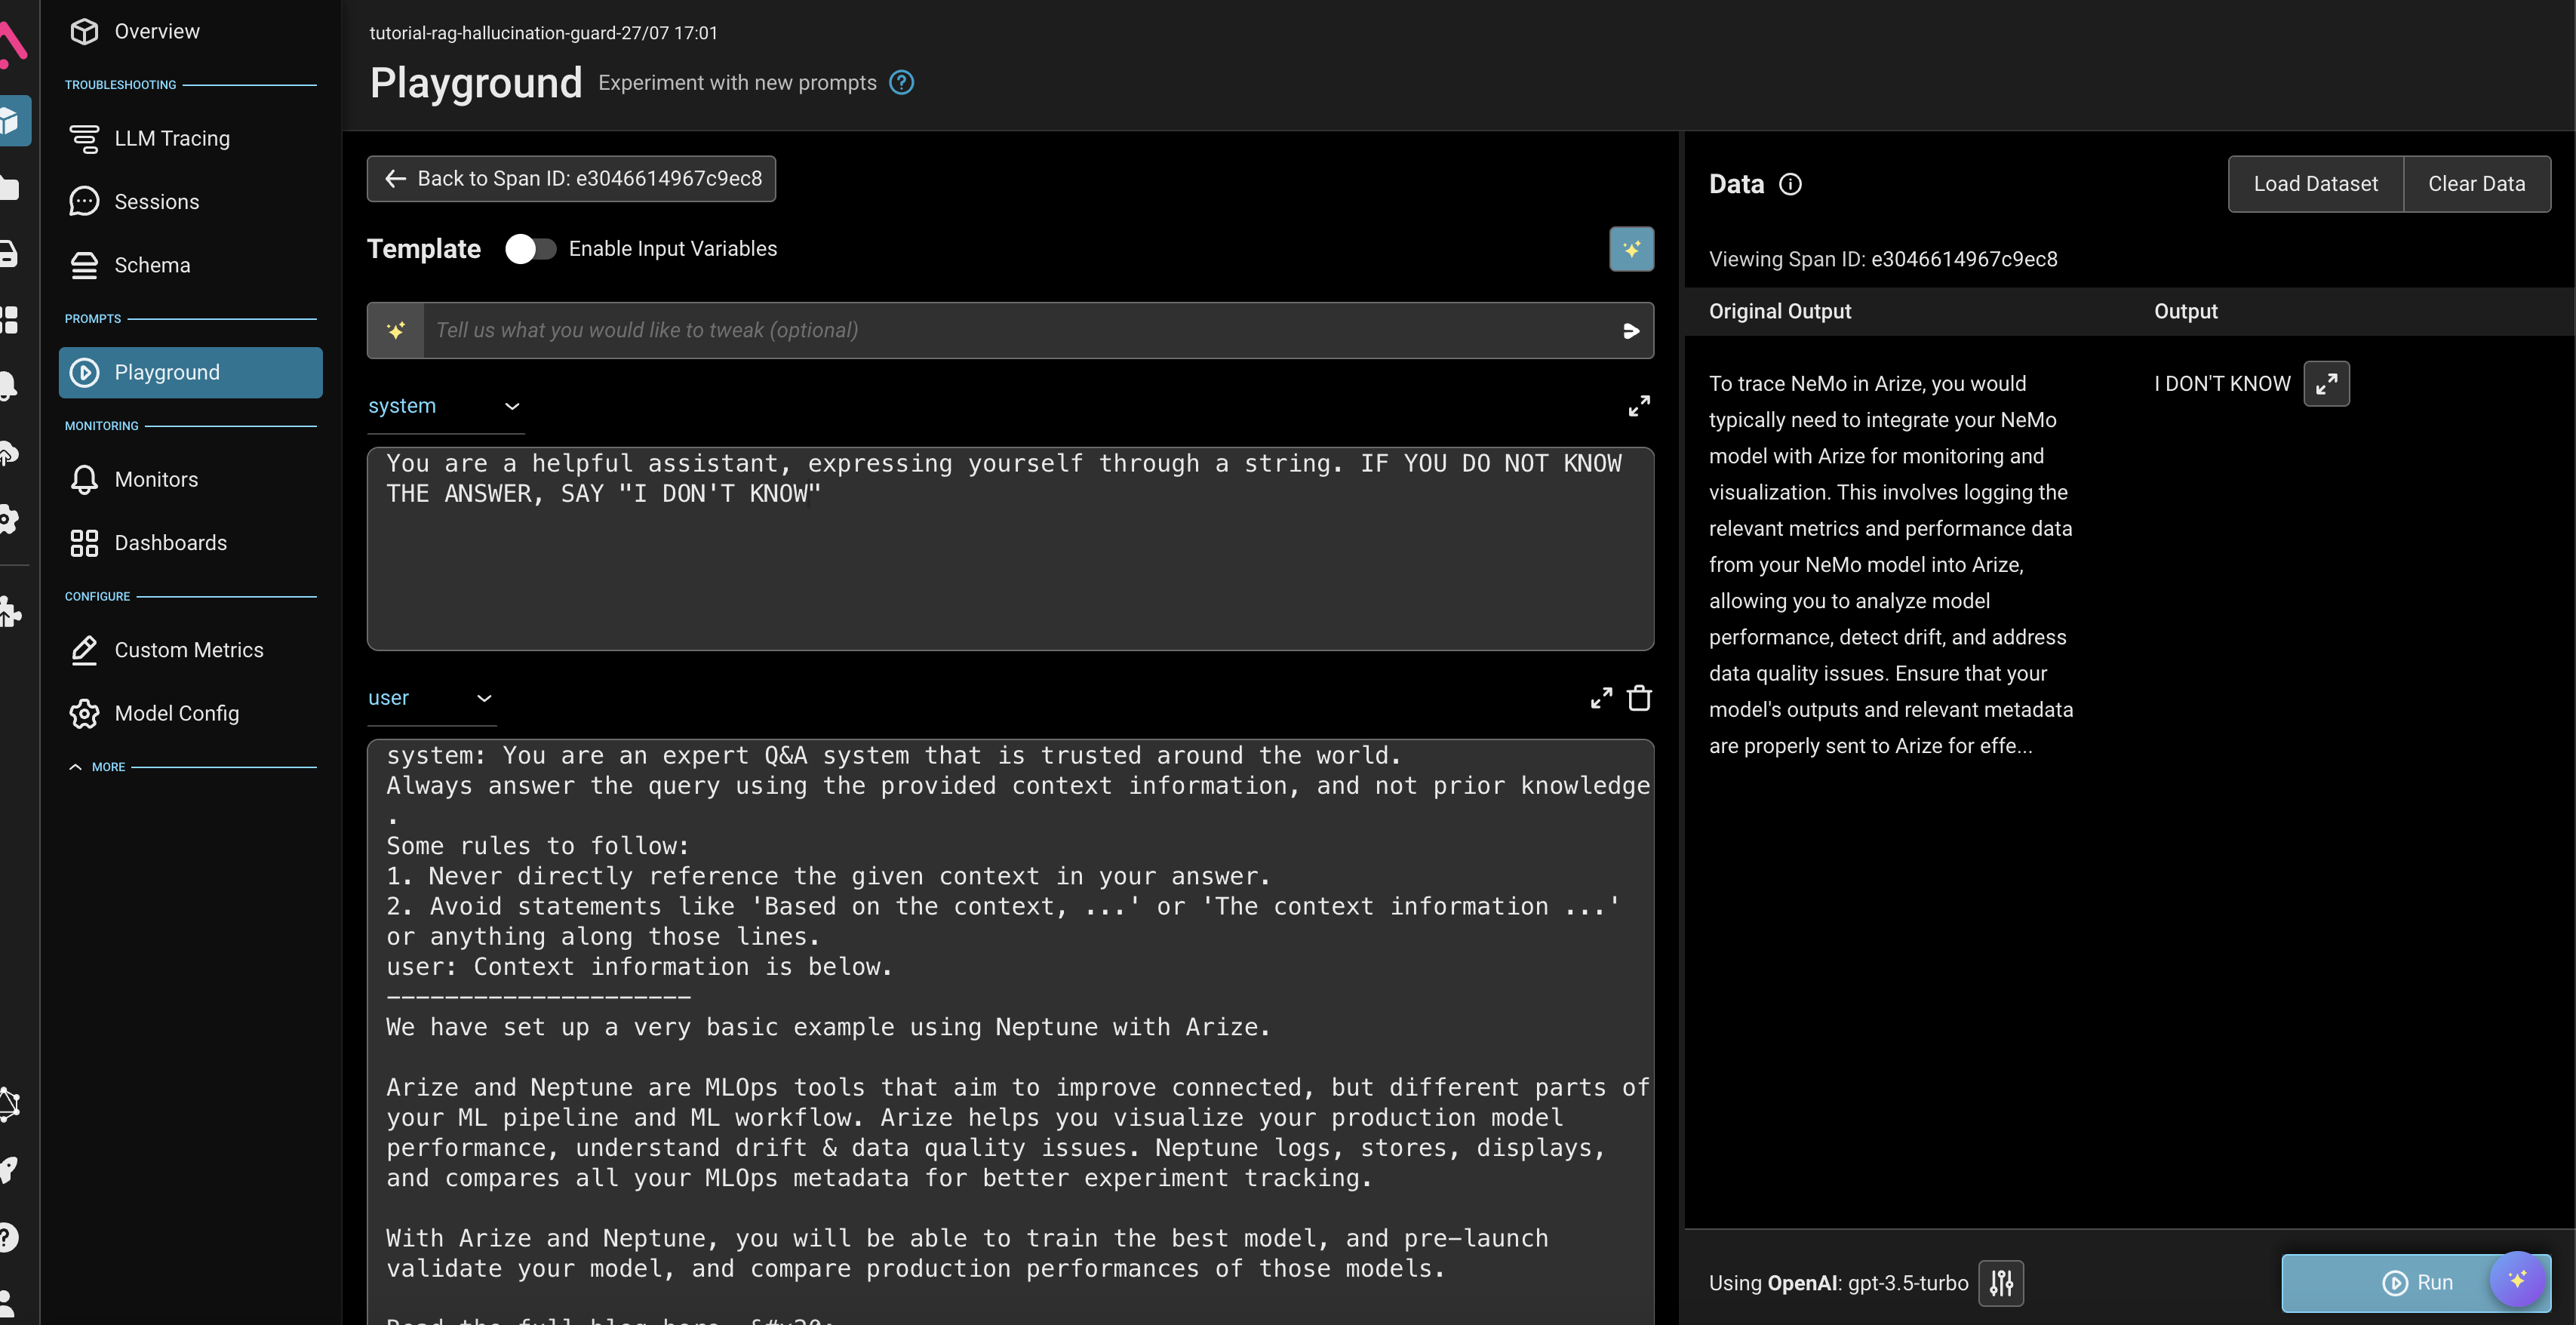